In [1]:
from google.colab import drive
import nltk
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U \
transformers \
torch \
scikit-learn \
pandas \
numpy==1.26.4 \
tqdm \
contractions \
captum \
matplotlib \
seaborn \
wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [112]:
import numpy as np
import wordcloud
print("NumPy:", np.__version__)
print("WordCloud:", wordcloud.__version__)


NumPy: 1.26.4
WordCloud: 1.9.5


In [3]:
#!pip install transformers torch scikit-learn pandas numpy tqdm contractions captum wordcloud seaborn

In [4]:
#!pip install wordcloud


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import (
RobertaTokenizer, RobertaForSequenceClassification,
Trainer,
TrainingArguments
)
#from transformers import RobertaTokenizer, RobertaForSequenceClassification
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load dataset
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
#df.head()

#print(df['class'].value_counts())
#print(len(df))

# Load dataset
df_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
df_all.head()

print(df_all['class'].value_counts())
print(len(df_all))

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
232074


#NOTE SECTION BELLOW

#WE NEED TO DOWNSAMPLE THE DATASET TO HELP FOR THE CODING. AFTER ALL IS DONE, THEN WE WILL REMOVE THIS SECTION TO RUN IT ON ALL THE CODE

In [3]:

df_all = df_all.drop_duplicates(subset='text')

N = 1000
df = df_all.groupby('class').apply(lambda x: x.sample(N, random_state=42)).reset_index(drop=True)

df.to_csv("/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/reduced/suicide_data_small.csv", index=False)

print(df['class'].value_counts())
print(len(df))


/tmp/ipython-input-740157602.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_all.groupby('class').apply(lambda x: x.sample(N, random_state=42)).reset_index(drop=True)


class
non-suicide    1000
suicide        1000
Name: count, dtype: int64
2000


In [4]:


# Confirm dataset structure
print(df.columns)
print(df['class'].value_counts())
print(df.shape)
list(df.columns)

df = df[["text", "class"]]
label_map = {"non-suicide": 0, "suicide": 1}
df["label"] = df["class"].map(label_map)

#PRINT FIRTH 10
df.head(10)

Index(['Unnamed: 0', 'text', 'class'], dtype='object')
class
non-suicide    1000
suicide        1000
Name: count, dtype: int64
(2000, 3)


,text,class,label
0,Used to keep it cool Used to be a fool \n\nAll...,non-suicide,0
1,"Well, haven't mat a girl like this in a while ...",non-suicide,0
2,My girlfriend just left me👍👍👍👍👍😁😁😁😁😁 I don't w...,non-suicide,0
3,Some people really don't want an anthro gf I'm...,non-suicide,0
4,how to break up with someone who is very much ...,non-suicide,0
5,WHY ME Every time I send a message. Always in ...,non-suicide,0
6,Simba’s an ungrateful lil bitch Sings an entir...,non-suicide,0
7,"I will be completely honest, Binod binod binod...",non-suicide,0
8,"Anyone else not have any friends, but not real...",non-suicide,0
9,Disgusting and Suspicious Tea Today my dad had...,non-suicide,0


###THIS IS TO SPLIT THE DATASET BEFORE CLEANING.

“Minimal text preprocessing was applied to preserve linguistic and emotional cues essential for transformer-based models. Unlike traditional machine learning pipelines, aggressive text normalisation was avoided to ensure meaningful attention distributions and faithful Integrated Gradient attributions.”

When we clean before spliting, we let  information from test data influence training data

Cleaning before splitting, cause risk of:

Vocabulary leakage, Distribution leakage, Over-optimistic performance, Invalid explainability results

BERT was trained on raw, messy, natural language, including:

punctuation, repetition, emotional intensity, informal text, subwords, casing (for cased models). IF we remove too much hurts performance and explainability. Therfore, for safe cleaning and minimal cleaning, we will perform: Lowercasing,Removing URLs

Removing HTML tags

Expanding contractions

Removing emojis

In [5]:
import re
import contractions
from sklearn.model_selection import train_test_split

###Clean functions

In [6]:
def clean_contractions(text):
    try:
        return contractions.fix(text)
    except:
        return text  # fallback if contractions fails

def remove_html_tags_func(text):
    return re.sub(r'<.*?>', '', text)

def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F018-\U0001F270"
        u"\U0001F650-\U0001F67F"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def clean_text_bert(text):
    text = str(text) if text else ""
    text = text.strip()
    if text == "":
        return ""
    text = clean_contractions(text)
    text = remove_html_tags_func(text)
    text = remove_url_func(text)
    text = remove_emoji(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

###Stratified Train-Test Split

In [7]:
train_df, val_df = train_test_split(
    df.copy(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

####Fill NaN & ensure strings

In [8]:
train_df['text'] = train_df['text'].fillna("").astype(str)
val_df['text']   = val_df['text'].fillna("").astype(str)

####Apply Cleaning

In [9]:
train_df['clean_text'] = train_df['text'].apply(clean_text_bert)
val_df['clean_text']   = val_df['text'].apply(clean_text_bert)

In [10]:
# Sample 5 random rows from each class
sample_class_1 = train_df[train_df['label'] == 1].sample(5, random_state=42)
sample_class_0 = train_df[train_df['label'] == 0].sample(5, random_state=42)

# Combine them and reset index
sample_train_df = pd.concat([sample_class_1, sample_class_0]).reset_index(drop=True)

# Display only the columns you want, like with head()
sample_train_df[[ 'text', 'clean_text', 'class', 'label']]

,text,clean_text,class,label
0,The night that changed my life forever. (TW: A...,the night that changed my life forever. (tw: a...,suicide,1
1,Chronic and Sustained Isolation (23M)* Every t...,chronic and sustained isolation (23m)* every t...,suicide,1
2,I can't take it anymoreIt just seems like my l...,i cannot take it anymoreit just seems like my ...,suicide,1
3,Why?Why should I keep living? I am 20 years ol...,why?why should i keep living? i am 20 years ol...,suicide,1
4,hurtingI need to vent... I've had attempts in ...,hurtingi need to vent... i have had attempts i...,suicide,1
5,Is it me or is everything funnier around 5-6am...,is it me or is everything funnier around 5-6am...,non-suicide,0
6,WHY IS MY APPLE JUICE BUBBLY BRO I JUST WANNA ...,why is my apple juice bubbly bro i just want t...,non-suicide,0
7,pepole keep taking pics of there dogs so heres...,pepole keep taking pics of there dogs so here ...,non-suicide,0
8,torrenting is slow It’s takin multiple hours t...,torrenting is slow it is takin multiple hours ...,non-suicide,0
9,I've got PTSD an I cant handle it I cant conce...,i have got ptsd an i cannot handle it i cannot...,non-suicide,0


###Extract lists for tokenization

In [11]:
train_texts  = train_df['clean_text'].tolist()
train_labels = train_df['label'].tolist()

val_texts    = val_df['clean_text'].tolist()
val_labels   = val_df['label'].tolist()


###Tokenize with Hugging Face BertTokenizer

In [12]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

###Dataset Wrapper

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer

####This is to Define batch size and device. We will use the approach of effective batch size batch_size = 8, gradient_accumulation_steps = 2, Effective batch size = 8 * 2 = 16. The optimizer will only update weights after accumulating gradients over 2 batches, effectively mimicking a batch of 16.

In [14]:
batch_size = 8
gradient_accumulation_steps = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


##Prepare Tokenizers and datasets

In [16]:

# Create Dataset objects
train_dataset = TokenizedDataset(train_encodings, train_labels)
val_dataset   = TokenizedDataset(val_encodings, val_labels)

###This is to Wrap into DataLoader for training

In [17]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)


In [18]:
batch = next(iter(train_loader))
print("input_ids:", batch['input_ids'].shape)        # [batch_size, max_len]
print("attention_mask:", batch['attention_mask'].shape)
print("labels:", batch['labels'].shape)


input_ids: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])
labels: torch.Size([8])


/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


###Difine model

In [19]:
from transformers import RobertaForSequenceClassification


num_labels = 2  # binary classification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_labels ,
    output_attentions=True
)

model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [20]:
#from transformers import RobertaForSequenceClassification


#num_labels = 2  # binary classification

#model = RobertaForSequenceClassification.from_pretrained(
 #   "roberta-base",
  #  num_labels=num_labels ,
   # output_attentions=True
#)

#model.to(device)


####This is to difine the optimizer

In [21]:
from torch.optim import AdamW


optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)


In [22]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_loader) * epochs // gradient_accumulation_steps

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [23]:
print(next(model.parameters()).device)


cuda:0


In [24]:
from tqdm import tqdm

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    loop = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch+1}",
        leave=True
    )

    optimizer.zero_grad()

    for step, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        #  tqdm live update
        loop.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished. Average loss: {avg_loss:.4f}")


Epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s, loss=0.0122]


Epoch 1 finished. Average loss: 0.4293


Epoch 2: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s, loss=0.0125]


Epoch 2 finished. Average loss: 0.1734


Epoch 3: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s, loss=0.0088]

Epoch 3 finished. Average loss: 0.0858


#EVALUATION OF ROBERTa#
##1. Confusion matrix 2. Precision, recall, F1 3. Classification report 4. Store correctly predicted suicide samples 5. Store correctly predicted non-suicide samples

In [25]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)

model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [26]:
all_preds = []
all_labels = []

correct_suicide_samples = []
correct_nonsuicide_samples = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=True):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store correctly predicted samples
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                if labels[i].item() == 1:
                    correct_suicide_samples.append(input_ids[i].cpu())
                else:
                    correct_nonsuicide_samples.append(input_ids[i].cpu())


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-1191073609.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 50/50 [00:02<00:00, 17.08it/s]


##CONFUSION MATRIX

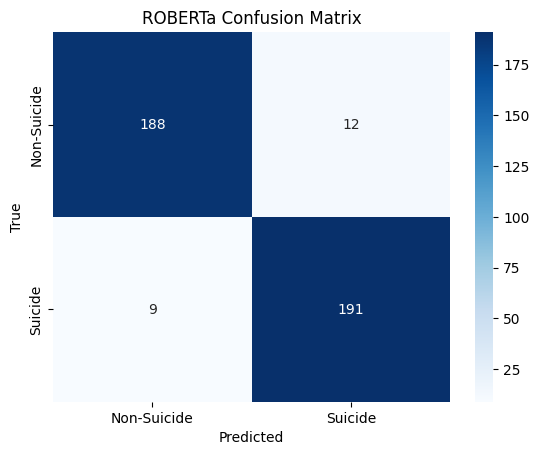

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Suicide', 'Suicide'],
            yticklabels=['Non-Suicide', 'Suicide'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ROBERTa Confusion Matrix')
plt.show()


#Precision, Recall, F1

In [28]:
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average='binary'
)

print(f"ROBERTa_Precision: {precision:.4f}")
print(f"ROBERTa_Recall:    {recall:.4f}")
print(f"ROBERTa_F1-score:  {f1:.4f}")


ROBERTa_Precision: 0.9409
ROBERTa_Recall:    0.9550
ROBERTa_F1-score:  0.9479


In [29]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=['Non-Suicide', 'Suicide']
    )
)


              precision    recall  f1-score   support

 Non-Suicide       0.95      0.94      0.95       200
     Suicide       0.94      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [30]:
def decode_samples(token_ids, tokenizer, max_samples=50):
    texts = []
    for ids in token_ids[:max_samples]:
        text = tokenizer.decode(ids, skip_special_tokens=True)
        texts.append(text)
    return texts


In [31]:
correct_suicide_texts = decode_samples(
    correct_suicide_samples,
    tokenizer
)

correct_nonsuicide_texts = decode_samples(
    correct_nonsuicide_samples,
    tokenizer
)


In [32]:
import pandas as pd

pd.DataFrame({'text': correct_suicide_texts}).to_csv(
    "/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_suicide_samples_roberta.csv", index=False
)

pd.DataFrame({'text': correct_nonsuicide_texts}).to_csv(
    '/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_nonsuicide_samples_roberta.csv', index=False
)


#EXPLAINABILITY AI ATTENTION + INTEGRATED GRADIENT

#NOTE

### What attention shows
##Attention answers: “Which words did ROBERTa focus on when forming its internal representation?”
In practice:
•	Attention scores show token-to-token influence
•	They highlight contextual importance
•	They are model-internal signals, not causal proofs

###Important limitation
##Attention ≠ Explanation by itself
This is a known research conclusion:
•	High attention ≠ high importance

##Attention shows where the model looks, not why the output changes
 So attention alone is insufficient for explainability


##TASK TO DO NEXT
####combine attention mechanisms and Integrated Gradients to identify both model focus and causal word-level contributions, highlighting their alignment and divergence”

###Select sample from sucide

####Tokinize the sample

In [33]:
#pick a sample
sample_text = correct_suicide_texts[8]

inputs = tokenizer(
    sample_text,
    return_tensors='pt',
    truncation=True,
    max_length=128
).to(device)


###Forward pass with attention extraction

In [34]:
model.eval()

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions


###Aggregate attention

In [35]:
import torch

# Average heads first → shape: (layers, tokens, tokens)
layer_attentions = torch.stack([layer.mean(dim=1).squeeze(0) for layer in attentions])

# Average across layers → overall attention
avg_attention = layer_attentions.mean(dim=0)  # shape: (tokens, tokens)

# CLS token attention to all tokens
cls_attention = avg_attention[0]  # shape: (tokens,)


####Merge WordPiece tokens into words

In [36]:
def merge_wordpieces(tokens, attention_scores):
    words = []
    word_scores = []

    current_word = ''
    current_score = 0.0
    count = 0

    for token, score in zip(tokens, attention_scores):
        if token.startswith('##'):
            current_word += token[2:]
            current_score += score
            count += 1
        else:
            if current_word != '':
                words.append(current_word)
                word_scores.append(current_score / count)
            current_word = token
            current_score = score
            count = 1

    # Append last word
    words.append(current_word)
    word_scores.append(current_score / count)

    return words, torch.tensor(word_scores)


In [37]:
tokens_raw = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Clean tokens
tokens = [t.replace("Ġ", "") for t in tokens_raw]


words, word_attention = merge_wordpieces(tokens, cls_attention.cpu())


###Heatmap of attention across tokens

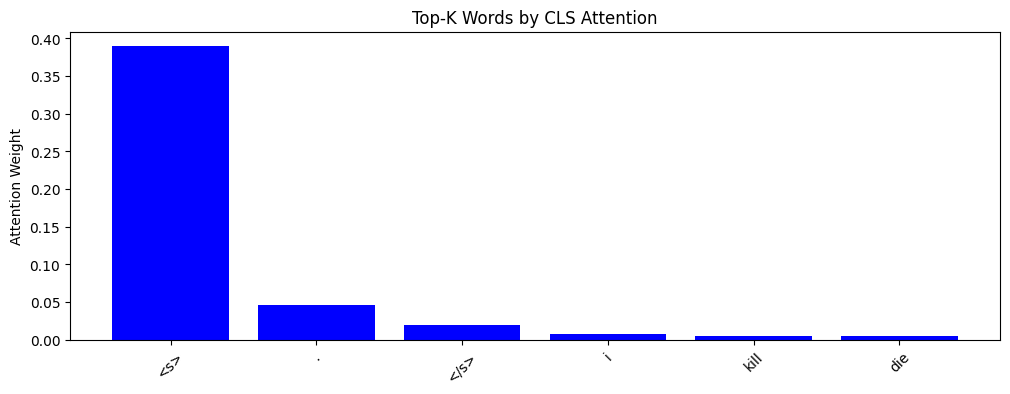

In [38]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15
top_indices = np.argsort(word_attention.numpy())[::-1][:top_k]
top_words = [words[i] for i in top_indices]

# Fix negative-stride issue
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]

plt.figure(figsize=(12,4))
plt.bar(top_words, top_values, color='blue')
plt.xticks(rotation=45)
plt.ylabel("Attention Weight")
plt.title("Top-K Words by CLS Attention")
plt.show()


In [39]:
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]


In [40]:
from matplotlib import cm
from IPython.core.display import display, HTML

def highlight_text(words, attention_scores):
    # Normalize
    scores = (attention_scores - attention_scores.min()) / (attention_scores.max() - attention_scores.min())
    cmap = cm.get_cmap('Reds')
    html = ''
    for word, score in zip(words, scores):
        color = cm.colors.to_hex(cmap(score))
        html += f'<span style="background-color:{color}">{word} </span>'
    return html

html = highlight_text(words, word_attention)
display(HTML(html))


/tmp/ipython-input-2452023492.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [41]:
cls_numpy = cls_attention.cpu().numpy()
top_values = cls_numpy[top_indices]


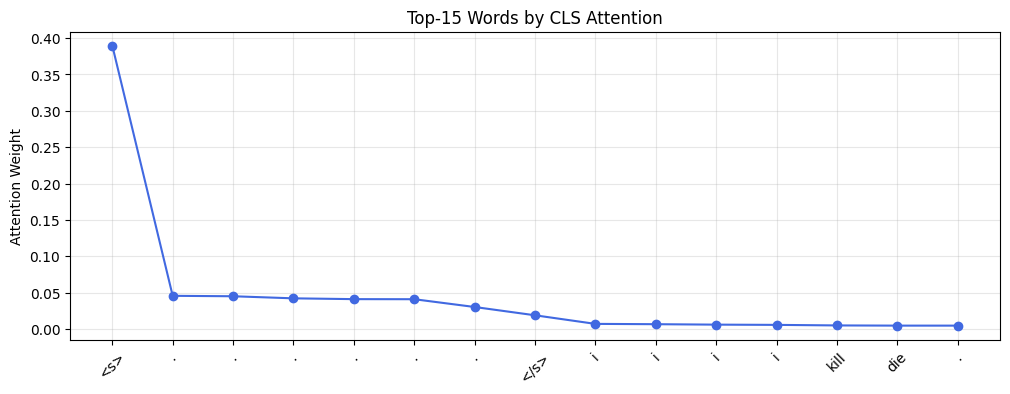

In [42]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15

# Convert to NumPy and fix negative-stride issues
word_attention_np = word_attention.numpy()

# Get top-K indices
top_indices = np.argsort(word_attention_np)[::-1][:top_k]

# Get top-K words and their attention scores
top_words = [words[i] for i in top_indices]
top_values = word_attention_np[top_indices]

# Plot like the first style (line plot with markers)
plt.figure(figsize=(12,4))
plt.plot(top_values, marker='o', linestyle='-', color='royalblue')
plt.xticks(range(top_k), top_words, rotation=45)
plt.ylabel("Attention Weight")
plt.title(f"Top-{top_k} Words by CLS Attention")
plt.grid(alpha=0.3)
plt.show()


In [43]:
token_importance = list(zip(tokens, cls_attention.cpu().numpy()))

# Sort by importance
token_importance = sorted(token_importance, key=lambda x: x[1], reverse=True)

for token, score in token_importance[:10]:
    print(f"{token}: {score:.4f}")


<s>: 0.3895
.: 0.0457
.: 0.0451
.: 0.0422
.: 0.0411
.: 0.0410
.: 0.0303
</s>: 0.0189
i: 0.0071
i: 0.0067


In [44]:
combined_attention = torch.zeros_like(attentions[0][0][0])

for layer in attentions:
    for head in layer[0]:
        combined_attention += head

combined_attention /= (len(attentions) * layer.shape[1])

cls_combined = combined_attention[0]
cls_combined /= cls_combined.sum()


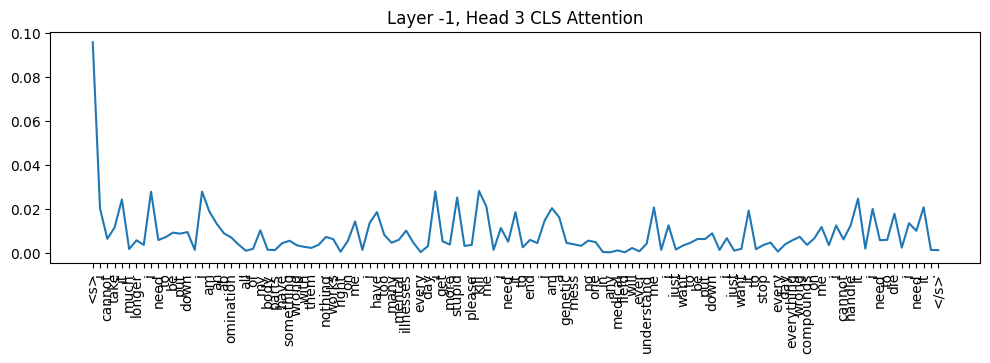

In [45]:
layer = -1
head = 3

head_attention = attentions[layer][0, head, 0].detach().cpu().numpy()

plt.figure(figsize=(12,3))
plt.plot(head_attention)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title(f"Layer {layer}, Head {head} CLS Attention")
plt.show()


###“Attention visualisation showed dominant focus on special tokens ([CLS], [SEP]) with diffuse distribution across content words. This supports prior findings that attention weights do not reliably correspond to feature importance. Therefore, Integrated Gradients were employed for faithful attribution.”

#INTEGRATED GRADIENTS

In [46]:
import torch
import numpy as np
from captum.attr import IntegratedGradients
from collections import defaultdict

In [47]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
).to(device)

model.eval()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

###IG inpute

In [48]:
def prepare_ig_inputs(input_ids, tokenizer):
    """
    Creates attention mask and PAD baseline IDs for IG.
    """
    attention_mask = (input_ids != tokenizer.pad_token_id).long()

    baseline_ids = torch.full_like(
        input_ids,
        tokenizer.pad_token_id
    )

    return attention_mask, baseline_ids


###Get RoBERTa Embeddings

In [49]:
def get_roberta_embeddings(model, input_ids):
    """
    Returns RoBERTa token embeddings for IG.
    """
    return model.roberta.embeddings(input_ids)


###Forward Function

In [50]:
def forward_func_roberta(embeddings, attention_mask):
    outputs = model.roberta(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )

    # IMPORTANT: pass full hidden states
    logits = model.classifier(outputs.last_hidden_state)

    return logits


###Run Integrated Gradients

In [51]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(forward_func_roberta)

# Pick ONE correctly predicted suicide sample
sample_ids = correct_suicide_samples[0].unsqueeze(0).to(device)

# Prepare inputs
attention_mask, baseline_ids = prepare_ig_inputs(sample_ids, tokenizer)

# Embeddings
input_embeddings = get_roberta_embeddings(model, sample_ids)
baseline_embeddings = get_roberta_embeddings(model, baseline_ids)

input_embeddings.requires_grad_(True)

# IG attribution
attributions, delta = ig.attribute(
    inputs=input_embeddings,
    baselines=baseline_embeddings,
    additional_forward_args=(attention_mask,),
    target=1,  # suicide class
    return_convergence_delta=True
)

print("Attributions shape:", attributions.shape)
print("Convergence delta:", delta.item())


Attributions shape: torch.Size([1, 128, 768])
Convergence delta: 0.003562048077583313


###Token-Level Attribution

###Token cleaning function

In [79]:
import string
import numpy as np
def clean_roberta_token_keep_boundary(token):
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(char in string.punctuation for char in token.replace("Ġ", "")):
        return ""
    return token


###Merge subwords into words

In [82]:
def merge_roberta_subwords(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = ""
    current_score = 0.0

    for tok, score in zip(tokens, scores):
        if tok == "":
            continue

        if tok.startswith("Ġ"):
            # Start of a NEW word
            if current_word != "":
                merged_tokens.append(current_word)
                merged_scores.append(current_score)

            current_word = tok.replace("Ġ", "")
            current_score = score
        else:
            # Continuation subword
            current_word += tok
            current_score += score

    if current_word != "":
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


#####RoBERTa subword attributions were aggregated to word-level importance by detecting word boundaries via the Ġ prefix and summing subword attributions accordingly.

###This is to Build token–IG table

In [86]:
# Clean tokens but KEEP Ġ
clean_tokens = [clean_roberta_token_keep_boundary(t) for t in tokens]

# Ensure scores are numpy
scores = (
    token_importance.detach().cpu().numpy()
    if torch.is_tensor(token_importance)
    else token_importance
)

merged_tokens, merged_scores = merge_roberta_subwords(clean_tokens, scores)

df_words = pd.DataFrame({
    "token": merged_tokens,
    "ig_score": merged_scores
})

df_words["abs_ig"] = df_words["ig_score"].abs()


In [56]:
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#df_words = df_words[~df_words["token"].isin(ENGLISH_STOP_WORDS)]


###Sort and Select top 20

In [87]:
top20_clean = (
    df_words
    .sort_values("abs_ig", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_clean.index += 1

print("\nTop-20 IG Words (RoBERTa — Cleaned & Merged):\n")
for i, row in top20_clean.iterrows():
    print(
        f"{i:>2}. {row.token:<20} "
        f"IG={row.ig_score:+.4f} | |IG|={row.abs_ig:.4f}"
    )



Top-20 IG Words (RoBERTa — Cleaned & Merged):

 1. deathemotionally     IG=+0.0104 | |IG|=0.0104
 2. definitely           IG=+0.0090 | |IG|=0.0090
 3. hope                 IG=+0.0051 | |IG|=0.0051
 4. to                   IG=-0.0034 | |IG|=0.0034
 5. today                IG=-0.0033 | |IG|=0.0033
 6. day                  IG=+0.0029 | |IG|=0.0029
 7. of                   IG=-0.0028 | |IG|=0.0028
 8. again                IG=+0.0026 | |IG|=0.0026
 9. i                    IG=+0.0025 | |IG|=0.0025
10. prefer               IG=+0.0025 | |IG|=0.0025
11. gonei                IG=+0.0023 | |IG|=0.0023
12. if                   IG=+0.0022 | |IG|=0.0022
13. this                 IG=-0.0022 | |IG|=0.0022
14. all                  IG=+0.0022 | |IG|=0.0022
15. think                IG=+0.0022 | |IG|=0.0022
16. to                   IG=-0.0021 | |IG|=0.0021
17. in                   IG=-0.0021 | |IG|=0.0021
18. every                IG=+0.0020 | |IG|=0.0020
19. day                  IG=-0.0020 | |IG|=0.0020
20

##Multiline Integrated Gradients heatmap for RoBERTa

###This is to Prepare token-level IG scores

In [88]:
# Sum across embedding dimension
token_importance = attributions.sum(dim=-1).squeeze(0)

# Detach & move to CPU
token_importance = token_importance.detach().cpu().numpy()

# Convert token IDs → tokens
tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))


###Clean tokens for RoBERTa heatmap

In [89]:
import string

def clean_roberta_token_for_heatmap(token):
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    token = token.replace("Ġ", "")  # remove space marker
    if token == "":
        return ""
    if all(char in string.punctuation for char in token):
        return ""
    return token


In [90]:
clean_tokens = [clean_roberta_token_for_heatmap(t) for t in tokens]


###Multiline IG heatmap

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import math

def visualize_token_heatmap_multiline(
    tokens,
    scores,
    title="Integrated Gradients Heatmap (RoBERTa)",
    tokens_per_row=20
):
    # Filter empty tokens
    filtered = [(t, s) for t, s in zip(tokens, scores) if t != ""]
    tokens, scores = zip(*filtered)

    scores = np.array(scores)

    # Normalize scores for color intensity
    scores_norm = scores / (np.max(np.abs(scores)) + 1e-8)

    num_tokens = len(tokens)
    num_rows = math.ceil(num_tokens / tokens_per_row)

    # Pad tokens and scores
    pad_len = num_rows * tokens_per_row - num_tokens
    tokens_padded = list(tokens) + [""] * pad_len
    scores_padded = np.pad(scores_norm, (0, pad_len), constant_values=0)

    token_matrix = np.array(tokens_padded).reshape(num_rows, tokens_per_row)
    score_matrix = scores_padded.reshape(num_rows, tokens_per_row)

    # Plot
    plt.figure(figsize=(tokens_per_row * 0.6, num_rows * 0.6))
    im = plt.imshow(score_matrix, cmap="RdBu_r", aspect="auto", vmin=-1, vmax=1)

    for i in range(num_rows):
        for j in range(tokens_per_row):
            tok = token_matrix[i, j]
            if tok != "":
                plt.text(j, i, tok, ha="center", va="center", fontsize=10)

    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, fraction=0.02, pad=0.02, label="Normalized IG score")
    plt.title(title)
    plt.tight_layout()
    plt.show()


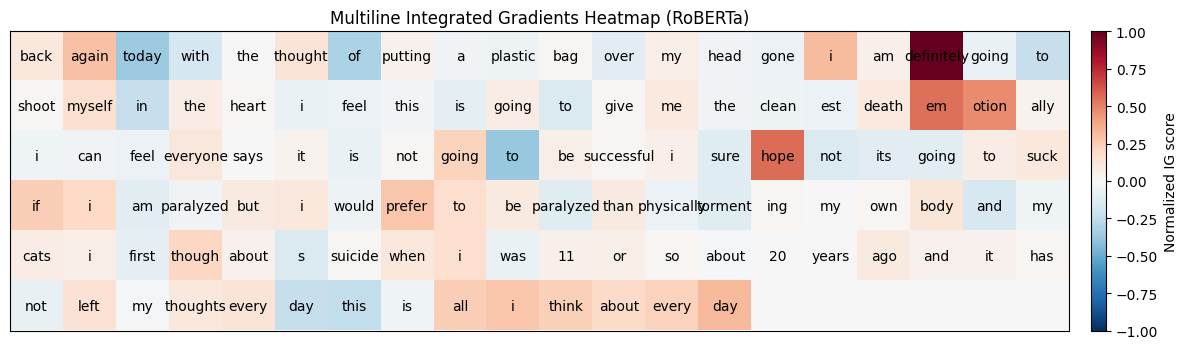

In [101]:
visualize_token_heatmap_multiline(
    clean_tokens,
    token_importance,
    title="Multiline Integrated Gradients Heatmap (RoBERTa)",
    tokens_per_row=20
)


#####Token-level attributions were visualized using a multiline heatmap, where Integrated Gradients scores were summed across the embedding dimension and normalized for visual comparison.”

####RoBERTa subword merging

In [113]:
def merge_roberta_tokens(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = ""
    current_score = 0.0

    for tok, score in zip(tokens, scores):
        if tok in ["<s>", "</s>", "<pad>"]:
            continue

        if tok.startswith("Ġ"):
            # New word
            if current_word:
                merged_tokens.append(current_word)
                merged_scores.append(current_score)
            current_word = tok[1:]   # remove Ġ
            current_score = score
        else:
            # Continuation subword
            current_word += tok
            current_score += score

    if current_word:
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


####Stopwords

In [114]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from collections import defaultdict

STOPWORDS = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###This is to Collect IG word scores

In [115]:
from collections import defaultdict
from captum.attr import IntegratedGradients
import torch

def collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=50
):
    model.eval()

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    ig = IntegratedGradients(forward_func_roberta)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)

        attention_mask = (sample_ids != tokenizer.pad_token_id).long()

        baseline_ids = torch.full_like(
            sample_ids, tokenizer.pad_token_id
        ).to(device)

        # Embeddings
        input_embeds = model.roberta.embeddings(sample_ids)
        baseline_embeds = model.roberta.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        # Integrated Gradients
        attributions, _ = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_class,
            return_convergence_delta=True
        )

        # Token-level IG
        token_importance = attributions.sum(dim=-1).squeeze(0)
        token_importance = token_importance / torch.norm(token_importance)

        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        words, scores = merge_roberta_subwords(
            tokens,
            token_importance.detach().cpu().numpy()
        )

        for w, s in zip(words, scores):
            w = w.lower()
            if len(w) < 3 or not w.isalpha():
                continue

            if s > 0:  # positive IG for suicide class
                word_scores[w] += s
                word_counts[w] += 1

    mean_word_scores = {
        w: word_scores[w] / word_counts[w]
        for w in word_scores
        if word_counts[w] >= 2
    }

    return mean_word_scores


###Word Cloud

In [121]:
import numpy as np

# PATCH numpy.asarray to ignore `copy`
_old_asarray = np.asarray
def _patched_asarray(a, *args, **kwargs):
    kwargs.pop("copy", None)
    return _old_asarray(a, *args, **kwargs)

np.asarray = _patched_asarray


In [122]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_ig_wordcloud(word_scores, title):
    wc = WordCloud(
        width=1000,
        height=400,
        background_color="white",
        colormap="Reds",
        max_words=100
    ).generate_from_frequencies(word_scores)

    plt.figure(figsize=(14, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


###Roberta Sucide class

In [123]:

print("NumPy:", np.__version__)
print("WordCloud:", wordcloud.__version__)


NumPy: 1.26.4
WordCloud: 1.9.5


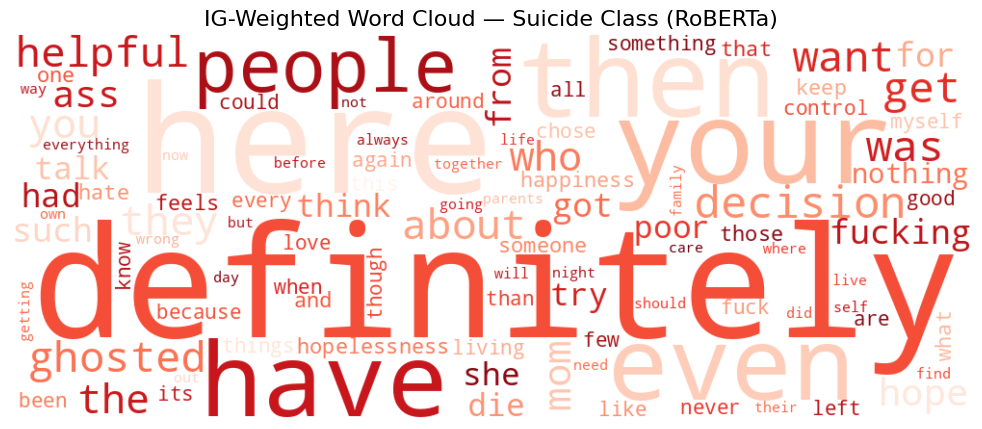

In [126]:
suicide_word_scores_roberta = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=50
)
plot_ig_wordcloud(
    suicide_word_scores_roberta,
    title="IG-Weighted Word Cloud — Suicide Class (RoBERTa)"
)



###Non-Suicide Word Cloud

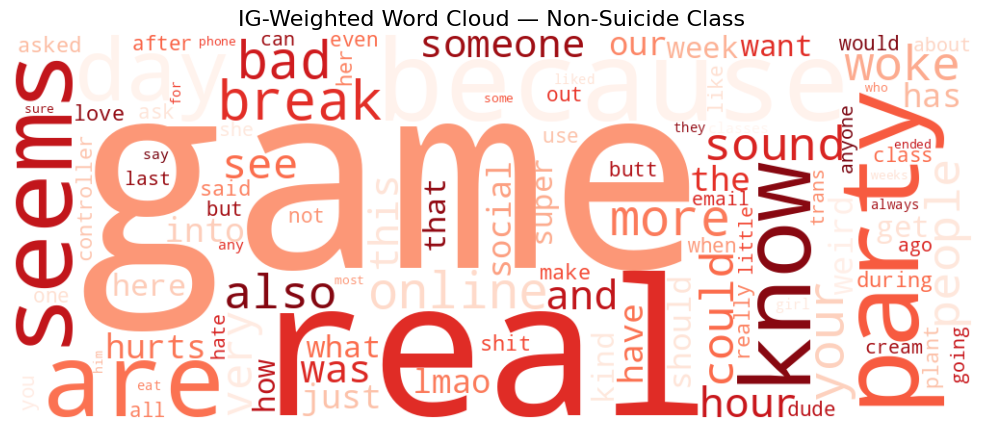

In [129]:
nonsuicide_word_scores_roberta = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=50
)

plot_ig_wordcloud(
    nonsuicide_word_scores_roberta,
    title="IG-Weighted Word Cloud — Non-Suicide Class"
)


##CONTRASTIVE INTEGRATED GRADIENTS (Suicide − Non-Suicide)

#####IGcontrast​(w)=E[IG(w∣Suicide)]−E[IG(w∣Non-Suicide)]

###Contrastive IG collector

In [130]:


def clean_roberta_token(token):
    token = token.replace("Ġ", "")
    if token in ["<s>", "</s>", "<pad>"]:
        return ""
    if all(c in string.punctuation for c in token):
        return ""
    return token.lower()


def collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=200,
    device="cuda"
):
    model.eval()
    ig = IntegratedGradients(forward_func_roberta)

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)
        attention_mask = (sample_ids != tokenizer.pad_token_id).long()

        baseline_ids = torch.full_like(
            sample_ids, tokenizer.pad_token_id
        ).to(device)

        input_embeds = model.roberta.embeddings(sample_ids)
        baseline_embeds = model.roberta.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        attributions = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_class
        )

        token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        for tok, score in zip(tokens, token_scores):
            tok = clean_roberta_token(tok)
            if tok == "" or len(tok) < 3:
                continue

            word_scores[tok] += score
            word_counts[tok] += 1

    # Average IG per word
    avg_word_scores = {
        w: word_scores[w] / word_counts[w]
        for w in word_scores
        if word_counts[w] >= 2
    }

    return avg_word_scores


###Compute contrastive IG

In [131]:
suicide_ig = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=300
)

nonsuicide_ig = collect_ig_scores_roberta(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=300
)

contrastive_ig = {
    w: suicide_ig[w] - nonsuicide_ig.get(w, 0.0)
    for w in suicide_ig
    if (suicide_ig[w] - nonsuicide_ig.get(w, 0.0)) > 0
}


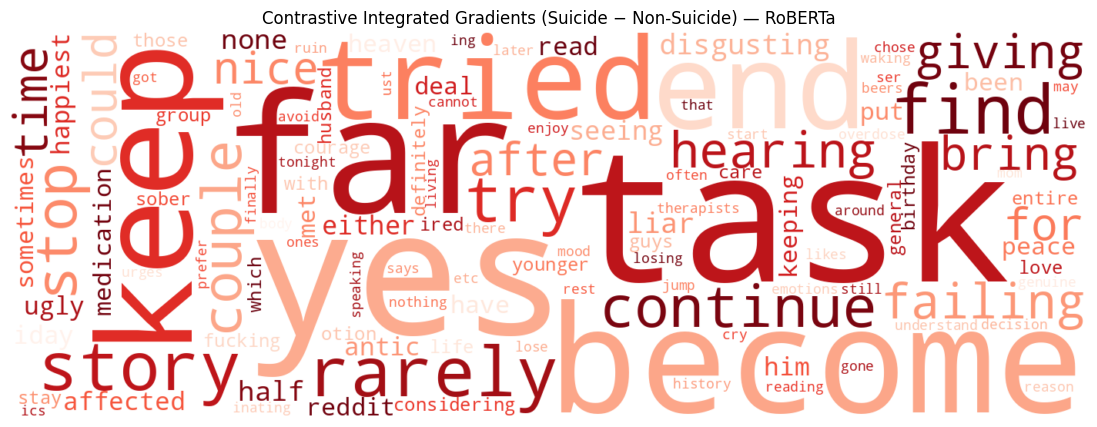

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    width=1400,
    height=500,
    background_color="white",
    colormap="Reds",
    max_words=120
).generate_from_frequencies(contrastive_ig)

plt.figure(figsize=(14,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Contrastive Integrated Gradients (Suicide − Non-Suicide) — RoBERTa")
plt.show()


###Why this is strong academically

Three levels of explainability was done:

1. IG per sample (local)

2. Aggregated IG (global)

3. Contrastive IG (class-discriminative)